In [168]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(rc={'figure.figsize':(30,30)})
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,VotingClassifier
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix,r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold,LeaveOneOut
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
train_sample = pd.read_csv('titanic_train_data.csv')
test_sample = pd.read_csv('titanic_test_data.csv')

In [3]:
train_sample

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Analyze Data

In [4]:
def Bar_plot(feature):
    survived = train_sample[train_sample['Survived']==1][feature].value_counts()
    dead = train_sample[train_sample['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['survived','dead']
    df.plot(kind='bar', stacked=False,figsize=(5,6))

 # SEX

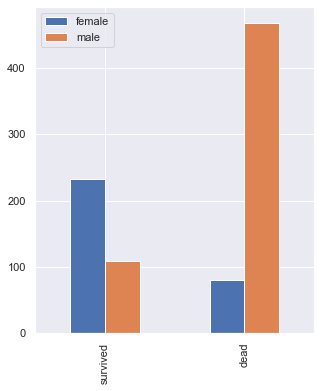

In [5]:
Bar_plot('Sex')

# CLASSES 

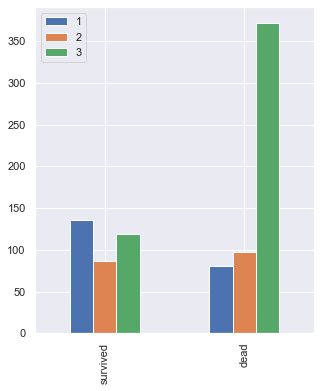

In [6]:
Bar_plot('Pclass')

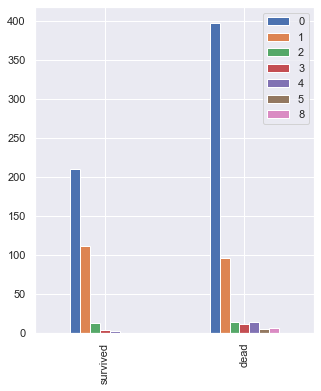

In [7]:
Bar_plot('SibSp')

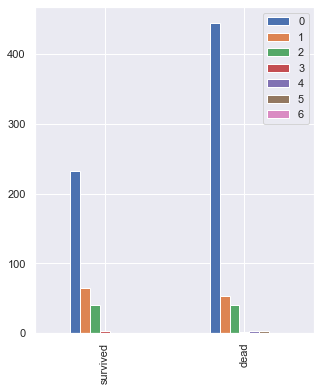

In [8]:
Bar_plot('Parch')

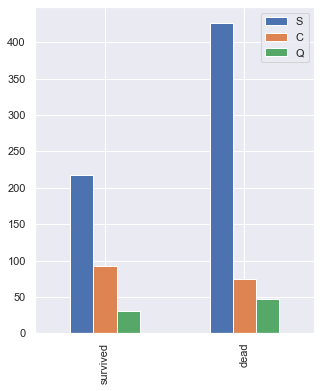

In [9]:
Bar_plot('Embarked')

In [10]:
train_test = [train_sample,test_sample] # combine datasets
for dataset in train_test:
    dataset['Title'] = dataset['Name'].str.extract('([A-Za-z]+)\.', expand=False)

In [11]:
title_mapping = {'Mr':0,'Miss':1,'Mrs':2,'Master':3,'Dr':3,'Rev':3,'Major':3,'Mlle':3,'Col':3,'Ms':3,'Countess':3,'Capt':3,
                'Sir':3,'Lady':3,'Mme':3,'Jonkheer':3,'Don':3}
for dataset in train_test:
    dataset['Title'] = dataset['Title'].map(title_mapping)

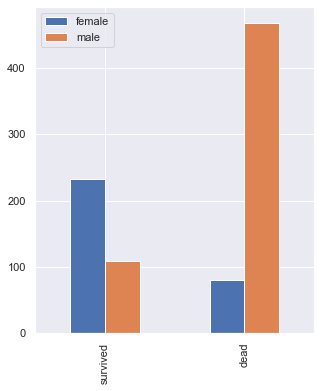

In [12]:
Bar_plot('Sex')

In [13]:
sex_mapping = {'male':0,'female':1}
for dataset in train_test:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

In [14]:
train_sample['Age'].fillna(train_sample.groupby('Title')['Age'].transform('median'),inplace=True)
test_sample['Age'].fillna(test_sample.groupby('Title')['Age'].transform('median'),inplace=True)

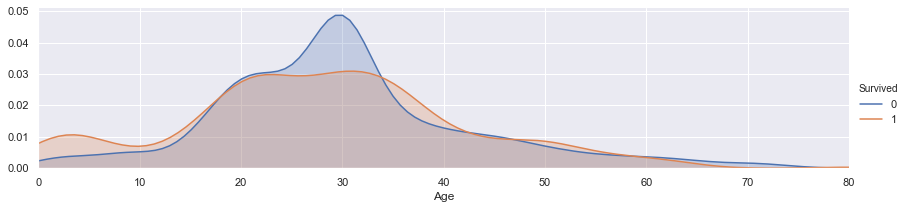

In [15]:
facet = sns.FacetGrid(train_sample,hue= 'Survived',aspect=4)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0,train_sample['Age'].max()))
facet.add_legend()
plt.show()

# BINNING

In [16]:
for dataset in train_test:
    dataset.loc[dataset['Age']<=16,'Age'] = 0
    dataset.loc[(dataset['Age']>16) & (dataset['Age']<=26),'Age'] = 1
    dataset.loc[(dataset['Age']>26) & (dataset['Age']<=36),'Age'] = 2
    dataset.loc[(dataset['Age']>36) & (dataset['Age']<=62),'Age'] = 3
    dataset.loc[dataset['Age']>16,'Age'] = 4

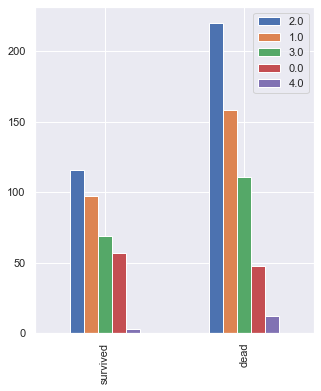

In [17]:
Bar_plot('Age')

In [18]:
for dataset in train_test:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [19]:
train_sample['Fare'].fillna(train_sample.groupby('Pclass')['Fare'].transform('median'),inplace=True)
test_sample['Fare'].fillna(test_sample.groupby('Pclass')['Fare'].transform('median'),inplace=True)

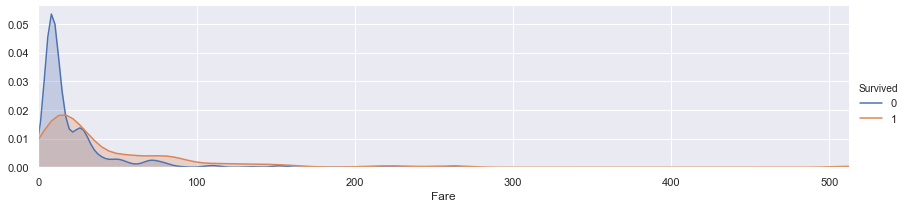

In [20]:
facet = sns.FacetGrid(train_sample,hue= 'Survived',aspect=4)
facet.map(sns.kdeplot,'Fare',shade=True)
facet.set(xlim=(0,train_sample['Fare'].max()))
facet.add_legend()
plt.show()

In [21]:
for dataset in train_test:
    dataset.loc[dataset['Fare']<=17,'Fare'] = 0
    dataset.loc[(dataset['Fare']>17) & (dataset['Fare']<=30),'Fare'] = 1
    dataset.loc[(dataset['Fare']>30) & (dataset['Fare']<=100),'Fare'] = 2
    dataset.loc[dataset['Fare']>100,'Fare'] = 3

In [22]:
for dataset in train_test:
    dataset['Cabin'] = dataset['Cabin'].str[:1]
train_sample['Cabin']

0      NaN
1        C
2      NaN
3        C
4      NaN
      ... 
886    NaN
887      B
888    NaN
889      C
890    NaN
Name: Cabin, Length: 891, dtype: object

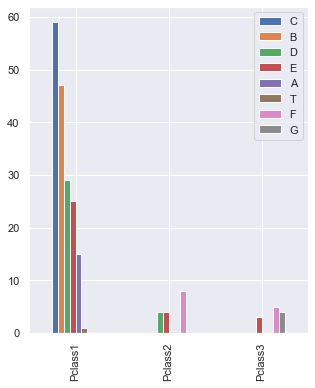

In [23]:
Pclass1 = train_sample[train_sample['Pclass']==1]['Cabin'].value_counts()
Pclass2 = train_sample[train_sample['Pclass']==2]['Cabin'].value_counts()
Pclass3 = train_sample[train_sample['Pclass']==3]['Cabin'].value_counts()
df = pd.DataFrame([Pclass1,Pclass2,Pclass3])
df.index = ['Pclass1','Pclass2','Pclass3']
df.plot(kind='bar', stacked=False,figsize=(5,6))

In [24]:
cabin_mapping = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'T':7}
for dataset in train_test:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)    
train_sample['Cabin']

0      NaN
1      2.0
2      NaN
3      2.0
4      NaN
      ... 
886    NaN
887    1.0
888    NaN
889    2.0
890    NaN
Name: Cabin, Length: 891, dtype: float64

In [25]:
train_sample['Cabin'].fillna(train_sample.groupby('Pclass')['Cabin'].transform('median'),inplace=True)
test_sample['Cabin'].fillna(test_sample.groupby('Pclass')['Cabin'].transform('median'),inplace=True)

In [26]:
train_sample['FamilySize'] = train_sample['SibSp'] + train_sample['Parch'] +1
test_sample['FamilySize'] = test_sample['SibSp'] + test_sample['Parch'] +1

In [27]:
family_mapping = {1:0,2:1,3:2,4:3,5:4,6:5,7:6,8:7,9:8,10:9,11:10}
for dataset in train_test:
    dataset['FamilySize'] = dataset['FamilySize'].map(family_mapping)

In [28]:
embark_mapping = {'S':0,'C':1,'Q':2}
for dataset in train_test:
    dataset['Embarked'] = dataset['Embarked'].map(embark_mapping)

In [29]:
test_sample['Title'] = dataset['Title'].fillna(0)

In [30]:
test_sample

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,892,3,"Kelly, Mr. James",0,2.0,0,0,330911,0.0,5.0,2,0.0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,3.0,1,0,363272,0.0,5.0,0,2.0,1
2,894,2,"Myles, Mr. Thomas Francis",0,3.0,0,0,240276,0.0,5.0,2,0.0,0
3,895,3,"Wirz, Mr. Albert",0,2.0,0,0,315154,0.0,5.0,0,0.0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1.0,1,1,3101298,0.0,5.0,0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",0,2.0,0,0,A.5. 3236,0.0,5.0,0,0.0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",1,3.0,0,0,PC 17758,3.0,2.0,1,0.0,0
415,1307,3,"Saether, Mr. Simon Sivertsen",0,3.0,0,0,SOTON/O.Q. 3101262,0.0,5.0,0,0.0,0
416,1308,3,"Ware, Mr. Frederick",0,2.0,0,0,359309,0.0,5.0,0,0.0,0


In [31]:
x = train_sample.iloc[:,[2,4,5,9,10,11,12,13]]
x

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,0,1.0,0.0,5.0,0,0,1
1,1,1,3.0,2.0,2.0,1,2,1
2,3,1,1.0,0.0,5.0,0,1,0
3,1,1,2.0,2.0,2.0,0,2,1
4,3,0,2.0,0.0,5.0,0,0,0
...,...,...,...,...,...,...,...,...
886,2,0,2.0,0.0,4.5,0,3,0
887,1,1,1.0,1.0,1.0,0,1,0
888,3,1,1.0,1.0,5.0,0,1,3
889,1,0,1.0,1.0,2.0,1,0,0


In [32]:
y = train_sample.iloc[:,1]

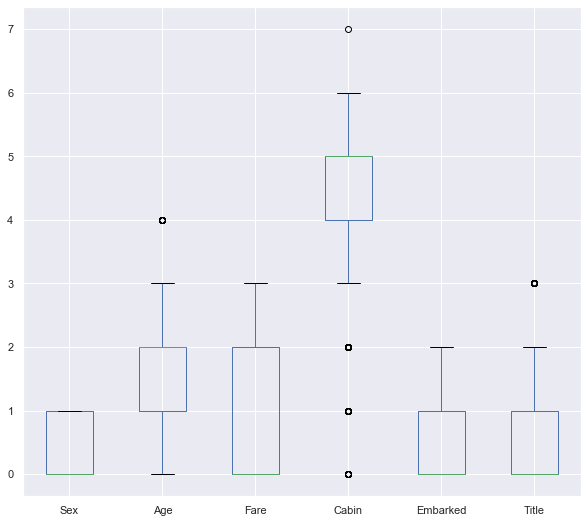

In [33]:
x.boxplot(column=['Sex','Age', 'Fare','Cabin','Embarked','Title'],figsize=(10,9))

# FEATURE SELECTION

In [34]:
#select k best methon

select_k_best = SelectKBest(chi2,k=5).fit(x,y)
sel_df = pd.DataFrame({'feature':list(x.columns),'scored':select_k_best.scores_})
sel_df.sort_values(by='scored',ascending= False)

,feature,scored
6,Title,233.656143
1,Sex,170.348127
3,Fare,94.134898
0,Pclass,30.873699
4,Cabin,30.390613
5,Embarked,11.353117
2,Age,4.023938
7,FamilySize,0.709091


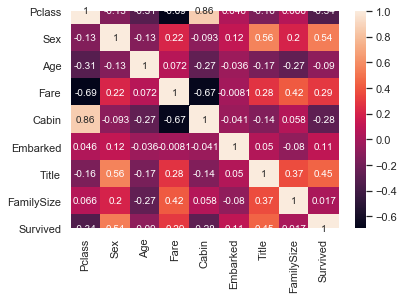

In [35]:
# correlation

co = pd.concat([x,y],axis=1)
co = co.corr()
ax = sns.heatmap(co, annot=True, fmt='.2g')

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.12099131 0.25981681 0.09171673 0.09003306 0.08639093 0.06105962
 0.18118682 0.10880472]


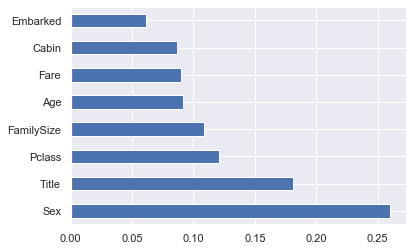

In [36]:
# Feature importance

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(x,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(30).plot(kind='barh')
plt.show()



In [37]:
# Use Recursive technique for feature selection

lg_clf = LogisticRegression()
selector = RFE(lg_clf,3,step=1)
selector.fit(x,y)

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\skl

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='warn', n_jobs=None, penalty='l2',
                                 random_state=None, solver='warn', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=3, step=1, verbose=0)

In [38]:
ranking= selector.ranking_
pd.DataFrame({'feature':list(x.columns),'ranking':ranking})

,feature,ranking
0,Pclass,1
1,Sex,1
2,Age,2
3,Fare,4
4,Cabin,6
5,Embarked,5
6,Title,1
7,FamilySize,3


In [39]:
train_first = x.loc[:,['Sex', 'Title','Pclass','Age','Fare','FamilySize','Cabin']]
test_first = test_sample.loc[:,['Sex', 'Title','Pclass','Age','Fare','FamilySize','Cabin']]

# Split data set into train and test set

In [40]:
#split data into training and test set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train_first,y,test_size=0.1,random_state=42)

In [41]:
y_train

165    1
541    0
625    0
388    0
76     0
      ..
106    1
270    0
860    0
435    1
102    0
Name: Survived, Length: 801, dtype: int64

# dealing with imbalanceness

In [148]:
# use up-sampling method

resamples = pd.concat([x_train,y_train],axis=1)
resamples

,Sex,Title,Pclass,Age,Fare,FamilySize,Cabin,Survived
165,0,3,3,0.0,1.0,2,5.0,1
541,1,1,3,0.0,2.0,6,5.0,0
625,0,0,1,3.0,2.0,0,3.0,0
388,0,0,3,2.0,0.0,0,5.0,0
76,0,0,3,2.0,0.0,0,5.0,0
...,...,...,...,...,...,...,...,...
106,1,1,3,1.0,0.0,0,5.0,1
270,0,0,1,2.0,2.0,0,2.0,0
860,0,0,3,3.0,0.0,2,5.0,0
435,1,1,1,0.0,3.0,3,1.0,1


In [149]:
yes = resamples[resamples.Survived==1]
no = resamples[resamples.Survived==0]
up_sample = resample(yes, replace=True, n_samples = len(no),random_state = 42)
balance_data = pd.concat([no,up_sample])
balance_data.Survived.value_counts()

1    495
0    495
Name: Survived, dtype: int64

In [44]:
b_d_x = balance_data.iloc[:,[0,1,2,3,4,5,6]]
b_d_y = balance_data.iloc[:,7]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


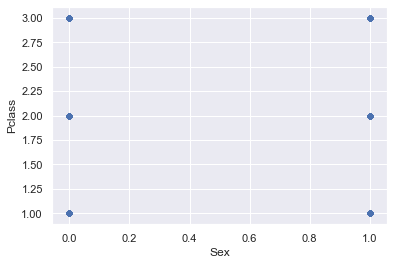

In [45]:
balance_data.plot.scatter(x='Sex',y='Pclass')

In [46]:
# scaling Features
sc = StandardScaler()
b_d_x = sc.fit_transform(b_d_x)
test_sd = sc.fit_transform(x_test)

# MAKING MODEL

In [47]:
xgboost = GradientBoostingClassifier(loss='deviance', learning_rate = 0.1,n_estimators=10)
xgboost.fit(b_d_x,b_d_y)
pred_xg=xgboost.predict(test_sd)

In [48]:
ac_xg = accuracy_score(y_test,pred_xg)
ac_xg

0.8222222222222222

In [49]:
f1_xg = f1_score(y_test,pred_xg)
f1_xg

0.7948717948717949

In [50]:
cv_score = cross_val_score(xgboost,b_d_x,b_d_y,cv=5)
cv_score.mean()

0.8020202020202021

# Logistic Regression

In [51]:
Log_clf = LogisticRegression(penalty='l2',random_state=None,solver='lbfgs',C=0.5)
Log_clf.fit(b_d_x,b_d_y)
pred_lg = Log_clf.predict(test_sd)
Log_clf.score(b_d_x,b_d_y)

0.797979797979798

In [52]:
ac_lg = accuracy_score(y_test,pred_lg)
ac_lg

0.8111111111111111

In [53]:
f1_lg = f1_score(y_test,pred_lg)
f1_lg

0.7848101265822784

# KNN

In [54]:
knn_clf = KNeighborsClassifier(n_neighbors=5,weights='distance',p=2,metric='minkowski')
knn_clf.fit(b_d_x,b_d_y)
knn_clf.score(b_d_x,b_d_y)

0.8505050505050505

In [55]:
pred_knn = knn_clf.predict(test_sd)

In [56]:
ac_knn = accuracy_score(y_test,pred_knn)
ac_knn

0.7555555555555555

In [57]:
f1_knn = f1_score(y_test,pred_knn)
f1_knn

0.738095238095238

# Cross-validation method for KNN

In [58]:
cv_score_knn = cross_val_score(knn_clf,b_d_x,b_d_y,cv=17)
cv_score_knn.mean()

0.7949290060851928

In [59]:
cv_pred_knn = cross_val_predict(knn_clf,test_sd,y_test,cv=19)

In [60]:
ac_cv_knn = accuracy_score(y_test,cv_pred_knn)
ac_cv_knn

0.8444444444444444

In [61]:
f1_cv_knn = f1_score(y_test,cv_pred_knn)
f1_cv_knn

0.7941176470588235

# Naive Bayes

In [62]:
nb_clf = GaussianNB()
nb_clf.fit(b_d_x,b_d_y)
nb_clf.score(b_d_x,b_d_y)

0.7737373737373737

In [63]:
pred_nb = nb_clf.predict(test_sd)
ac_nb = accuracy_score(y_test,pred_nb)
ac_nb

0.7777777777777778

In [64]:
f1_nb = f1_score(y_test,pred_nb)
f1_nb

0.7727272727272727

# Random Forest

In [65]:
rnd_clf = RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=None)
rnd_clf.fit(b_d_x,b_d_y)
rnd_clf.score(b_d_x,b_d_y)

0.8737373737373737

In [66]:
pred_rnd = rnd_clf.predict(test_sd)
ac_rnd = accuracy_score(y_test,pred_rnd)
ac_rnd

0.8444444444444444

In [67]:
f1_rnd = f1_score(y_test,pred_rnd)
f1_rnd

0.8108108108108109

# Support Vector Machine

In [68]:
svc_clf = SVC(C=1.0,kernel='rbf',random_state=None,degree=3, gamma=0.001)
svc_clf.fit(b_d_x,b_d_y)
svc_clf.score(b_d_x,b_d_y)

0.7696969696969697

In [69]:
pred_svc = svc_clf.predict(test_sd)

In [70]:
ac_svc = accuracy_score(y_test,pred_svc)
ac_svc

0.7777777777777778

In [71]:
f1_svc = f1_score(y_test,pred_svc) 
f1_svc

0.7499999999999999

# Ada-Boosting

In [72]:
ad_boost = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,n_estimators=10, random_state=None)
ad_boost.fit(b_d_x,b_d_y)
ad_boost.score(b_d_x,b_d_y)

0.7696969696969697

In [73]:
ad_pred = ad_boost.predict(test_sd)
ad_ac = accuracy_score(y_test,ad_pred)
ad_ac

0.7777777777777778

In [74]:
f1_ad = f1_score(y_test,ad_pred)
f1_ad

0.7499999999999999

# Make table of model performance


In [75]:
models = np.array([[ac_xg,f1_xg],[ac_lg,f1_lg],[ac_cv_knn,f1_cv_knn],[ac_nb,f1_nb],[ac_rnd,f1_rnd],[ac_svc,f1_svc],[ad_ac,f1_ad]])
perf_ = pd.DataFrame(models,index=['Xgboost','Logistic Regression','KNN','Naive Bayes', 'Random Forest','SVC','Ada-boost'],columns=['Accuracy', 'F1'])
perf_.sort_values(by='F1',ascending= False)

,Accuracy,F1
Random Forest,0.844444,0.810811
Xgboost,0.822222,0.794872
KNN,0.844444,0.794118
Logistic Regression,0.811111,0.784810
Naive Bayes,0.777778,0.772727
SVC,0.777778,0.750000
Ada-boost,0.777778,0.750000


# Hyper-perameter Tuning

In [76]:
# Grid Sreach for xgboost
para = [{'loss':['deviance'],'learning_rate':[0.1,0.3,0.5,0.7,1.0],
         'n_estimators':[10,50,100,200,500]},{'loss':['exponential'],'learning_rate':[0.1,0.3,0.5,0.7,1.0],'n_estimators':[10,50,100,200,500]}]
xg_gr_clf = GridSearchCV(xgboost,para,n_jobs=-1)
xg_gr_clf.fit(b_d_x,b_d_y)

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=10,
                                                  n_ite...
                                                  validation_fractio

In [77]:
xg_gr_clf.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [78]:
# grid sreach for Logistic Regression
para_2 = [{'solver': ['lbfgs'],'penalty':['l2'],'C':[0.5]},{'solver': ['liblinear'],'C':[0.5]}]
lg_gr_clf = GridSearchCV(Log_clf,para_2,)
lg_gr_clf.fit(b_d_x,b_d_y)

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=0.5, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.5], 'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': [0.5], 'solver': ['liblinear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [79]:
lg_gr_clf.best_estimator_

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [80]:
# Grid search for Random Forest
para_3 = [{'n_estimators':[10,50,70,100,500,1000],'criterion':['entropy']},{'n_estimators':[10,50,70,100,500,1000],'criterion':['gini']}]
rnd_gr_clf  = GridSearchCV(rnd_clf,para_3)
rnd_gr_clf.fit(b_d_x,b_d_y)

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                               

In [81]:
rnd_gr_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [82]:
# grid search for SVC
para_4 = [{'kernel':['rbf'],'gamma':[0.001,0.01,0.5,1.0]},
          {'kernel':['poly'],'degree':[2,3,4,5],'gamma':[0.001,0.01,0.5,1.0]},
          {'kernel':['sigmoid'],'gamma':[0.001,0.01,0.5,1.0]},{'kernel':['linear'],'gamma':[0.001,0.01,0.5,1.0]}]
svc_gr_clf = GridSearchCV(svc_clf,para_4)
svc_gr_clf.fit(b_d_x,b_d_y)

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3, gamma=0.001,
                           kernel='rbf', max_iter=-1, probability=False,
                           random_state=None, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'gamma': [0.001, 0.01, 0.5, 1.0], 'kernel': ['rbf']},
                         {'degree': [2, 3, 4, 5],
                          'gamma': [0.001, 0.01, 0.5, 1.0],
                          'kernel': ['poly']},
                         {'gamma': [0.001, 0.01, 0.5, 1.0],
                          'kernel': ['sigmoid']},
                         {'gamma': [0.001, 0.01, 0.5, 1.0],
                          'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=N

In [83]:
svc_gr_clf.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [84]:
# grid search for ada boost
para_5 = [{'n_estimators':[10,20,50,70,100,200,500,1000],'learning_rate':[0.01,0.05,0.1,0.5],'algorithm':['SAMME.R']},
         {'n_estimators':[10,20,50,70,100,200,500,1000],'learning_rate':[0.01,0.05,0.1,0.5],'algorithm':['SAMME']}]
ada_gr_clf = GridSearchCV(ad_boost,para_5)
ada_gr_clf.fit(b_d_x,b_d_y)

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=0.01, n_estimators=10,
                                          random_state=None),
             iid='warn', n_jobs=None,
             param_grid=[{'algorithm': ['SAMME.R'],
                          'learning_rate': [0.01, 0.05, 0.1, 0.5],
                          'n_estimators': [10, 20, 50, 70, 100, 200, 500,
                                           1000]},
                         {'algorithm': ['SAMME'],
                          'learning_rate': [0.01, 0.05, 0.1, 0.5],
                          'n_estimators': [10, 20, 50, 70, 100, 200, 500,
                                           1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [85]:
ada_gr_clf.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.05,
                   n_estimators=500, random_state=None)

# Voting Classifier

In [86]:
vt_clf = VotingClassifier(estimators=[('xgboost',xgboost),('lg',Log_clf),('rnd',rnd_clf),('knn',knn_clf)],voting='hard') #('nb',nb_clf)('svc',svc_clf),('ad',ad_boost)
vt_clf.fit(b_d_x,b_d_y)
vt_clf.score(b_d_x,b_d_y)

0.8565656565656565

In [87]:
vt_pred = vt_clf.predict(test_sd)

In [88]:
ac_vt = accuracy_score(y_test,vt_pred)
ac_vt

0.8555555555555555

In [89]:
f1_vt = f1_score(y_test,vt_pred)
f1_vt

0.8219178082191781

# Cross validation LeaveOneOut

In [90]:
# standardize main train data
sc = StandardScaler()
ts = sc.fit_transform(train_first)

In [91]:
cvs = LeaveOneOut()
cv_vt = cross_validate(vt_clf,ts,y,cv=5)

In [92]:
cv_vt


{'fit_time': array([0.05896664, 0.07595587, 0.05296946, 0.04797363, 0.04698873]),
 'score_time': array([0.01099348, 0.00999451, 0.00801206, 0.00997806, 0.00799441]),
 'test_score': array([0.83240223, 0.81564246, 0.83707865, 0.80337079, 0.85875706])}

In [93]:
pred_vt_cv= cross_val_predict(vt_clf,ts,y,cv=5)

In [94]:
acc_vt_cv = accuracy_score(y,pred_vt_cv)
acc_vt_cv

0.8237934904601572

In [95]:
f1_vt_cv = f1_score(y,pred_vt_cv)
f1_vt_cv

0.7471819645732688

# Create Dummy variables

In [96]:
train_first

,Sex,Title,Pclass,Age,Fare,FamilySize,Cabin
0,0,0,3,1.0,0.0,1,5.0
1,1,2,1,3.0,2.0,1,2.0
2,1,1,3,1.0,0.0,0,5.0
3,1,2,1,2.0,2.0,1,2.0
4,0,0,3,2.0,0.0,0,5.0
...,...,...,...,...,...,...,...
886,0,3,2,2.0,0.0,0,4.5
887,1,1,1,1.0,1.0,0,1.0
888,1,1,3,1.0,1.0,3,5.0
889,0,0,1,1.0,1.0,0,2.0


In [190]:
train_first['Title'].value_counts()

0    517
1    182
2    125
3     67
Name: Title, dtype: int64

In [97]:
t_t = []
for j in train_first['Title']:
    if j == 0:
        t_t.append(1)
    else: 
        t_t.append(0)
train_first['Title_0']= t_t        

In [98]:
t_1 = []
for j in train_first['Title']:
    if j == 1:
        t_1.append(1)
    else: 
        t_1.append(0)
train_first['Title_1']= t_1        

In [99]:
t_2 = []
for j in train_first['Title']:
    if j == 2:
        t_2.append(1)
    else: 
        t_2.append(0)
train_first['Title_2']= t_2        

In [100]:
t_3 = []
for j in train_first['Title']:
    if j == 3:
        t_3.append(1)
    else: 
        t_3.append(0)
train_first['Title_3']= t_3     

In [101]:
p_1 = []
for j in train_first['Pclass']:
    if j == 1:
        p_1.append(1)
    else: 
        p_1.append(0)
train_first['Pclass_1']= p_1     

In [102]:
p_2 = []
for j in train_first['Pclass']:
    if j == 2:
        p_2.append(1)
    else: 
        p_2.append(0)
train_first['Pclass_2']= p_2     

In [103]:
p_3 = []
for j in train_first['Pclass']:
    if j == 3:
        p_3.append(1)
    else: 
        p_3.append(0)
train_first['Pclass_3']= p_3     

In [104]:
train_first.Age.value_counts()

2.0    336
1.0    255
3.0    180
0.0    105
4.0     15
Name: Age, dtype: int64

In [105]:
a_0 = []
for j in train_first['Age']:
    if j == 0:
        a_0.append(1)
    else: 
        a_0.append(0)
train_first['Age_0']= a_0 

In [106]:
a_1 = []
for j in train_first['Age']:
    if j == 1:
        a_1.append(1)
    else: 
        a_1.append(0)
train_first['Age_1']= a_1 

In [107]:
a_2 = []
for j in train_first['Age']:
    if j == 2:
        a_2.append(1)
    else: 
        a_2.append(0)
train_first['Age_2']= a_2 

In [108]:
a_3 = []
for j in train_first['Age']:
    if j == 3:
        a_3.append(1)
    else: 
        a_3.append(0)
train_first['Age_3']= a_3 

In [109]:
a_4 = []
for j in train_first['Age']:
    if j == 4:
        a_4.append(1)
    else: 
        a_4.append(0)
train_first['Age_4']= a_4 

In [110]:
train_first.Fare.value_counts()

0.0    496
2.0    181
1.0    161
3.0     53
Name: Fare, dtype: int64

In [111]:
f_0 = []
for j in train_first['Fare']:
    if j == 0:
        f_0.append(1)
    else: 
        f_0.append(0)
train_first['Fare_0']= f_0 

In [112]:
f_1 = []
for j in train_first['Fare']:
    if j == 1:
        f_1.append(1)
    else: 
        f_1.append(0)
train_first['Fare_1']= f_1 

In [113]:
f_2 = []
for j in train_first['Fare']:
    if j == 2:
        f_2.append(1)
    else: 
        f_2.append(0)
train_first['Fare_2']= f_2 

In [114]:
f_3 = []
for j in train_first['Fare']:
    if j == 3:
        f_3.append(1)
    else: 
        f_3.append(0)
train_first['Fare_3']= f_3 

In [119]:
Fs_0 = []
for j in train_first['FamilySize']:
    if j == 0:
        Fs_0.append(1)
    else: 
        Fs_0.append(0)
train_first['FamilySize_0']= Fs_0 

In [128]:
Fs_1 = []
for j in train_first['FamilySize']:
    if j == 1:
        Fs_1.append(1)
    else: 
        Fs_1.append(0)
train_first['FamilySize_1']= Fs_1 

In [131]:
Fs_2 = []
for j in train_first['FamilySize']:
    if j == 2:
        Fs_2.append(1)
    else: 
        Fs_2.append(0)
train_first['FamilySize_2']= Fs_2 

In [133]:
Fs_3 = []
for j in train_first['FamilySize']:
    if j == 3:
        Fs_3.append(1)
    else: 
        Fs_3.append(0)
train_first['FamilySize_2']= Fs_3 

In [134]:
Fs_4 = []
for j in train_first['FamilySize']:
    if j == 4:
        Fs_4.append(1)
    else: 
        Fs_4.append(0)
train_first['FamilySize_4']= Fs_4 

In [135]:
Fs_5 = []
for j in train_first['FamilySize']:
    if j == 5:
        Fs_5.append(1)
    else: 
        Fs_5.append(0)
train_first['FamilySize_4']= Fs_5 

In [136]:
Fs_6 = []
for j in train_first['FamilySize']:
    if j == 6:
        Fs_6.append(1)
    else: 
        Fs_6.append(0)
train_first['FamilySize_6']= Fs_6 

In [137]:
Fs_7 = []
for j in train_first['FamilySize']:
    if j == 7:
        Fs_7.append(1)
    else: 
        Fs_7.append(0)
train_first['FamilySize_7']= Fs_7 

In [139]:
Fs_10 = []
for j in train_first['FamilySize']:
    if j == 10:
        Fs_10.append(1)
    else: 
        Fs_10.append(0)
train_first['FamilySize_10']= Fs_10 

In [129]:
train_first.FamilySize.value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: FamilySize, dtype: int64

In [140]:
train_first

,Sex,Title,Pclass,Age,Fare,FamilySize,Cabin,Title_0,Title_1,Title_2,...,Fare_1,Fare_2,Fare_3,FamilySize_0,FamilySize_1,FamilySize_2,FamilySize_4,FamilySize_6,FamilySize_7,FamilySize_10
0,0,0,3,1.0,0.0,1,5.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,2,1,3.0,2.0,1,2.0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
2,1,1,3,1.0,0.0,0,5.0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,1,2,1,2.0,2.0,1,2.0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
4,0,0,3,2.0,0.0,0,5.0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,3,2,2.0,0.0,0,4.5,0,0,0,...,0,0,0,1,0,0,0,0,0,0
887,1,1,1,1.0,1.0,0,1.0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
888,1,1,3,1.0,1.0,3,5.0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
889,0,0,1,1.0,1.0,0,2.0,1,0,0,...,1,0,0,1,0,0,0,0,0,0


In [261]:
s_dummy_x = train_first.iloc[:,[0,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]]
s_dummy_x

,Sex,Cabin,Title_0,Title_1,Title_2,Title_3,Pclass_1,Pclass_2,Pclass_3,Age_0,...,Fare_1,Fare_2,Fare_3,FamilySize_0,FamilySize_1,FamilySize_2,FamilySize_4,FamilySize_6,FamilySize_7,FamilySize_10
0,0,5.0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,2.0,0,0,1,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,1,5.0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,1,2.0,0,0,1,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,0,5.0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,4.5,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
887,1,1.0,0,1,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
888,1,5.0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
889,0,2.0,1,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [262]:
d_x_train,d_x_test,d_y_train,d_y_test = train_test_split(s_dummy_x,y,test_size=0.2,random_state=42)

In [263]:
d_resamples = pd.concat([d_x_train,d_y_train],axis=1)
d_resamples

,Sex,Cabin,Title_0,Title_1,Title_2,Title_3,Pclass_1,Pclass_2,Pclass_3,Age_0,...,Fare_2,Fare_3,FamilySize_0,FamilySize_1,FamilySize_2,FamilySize_4,FamilySize_6,FamilySize_7,FamilySize_10,Survived
331,0,2.0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
733,0,4.5,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
382,0,5.0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
704,0,5.0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
813,1,5.0,0,1,0,0,0,0,1,1,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1,5.0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
270,0,2.0,1,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
860,0,5.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
435,1,1.0,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1


In [264]:
d_yes = d_resamples[d_resamples.Survived==1]
d_no = d_resamples[d_resamples.Survived==0]
d_up_sample = resample(d_yes, replace=True, n_samples = len(d_no),random_state = 42)
d_balance_data = pd.concat([d_no,d_up_sample])
d_balance_data.Survived.value_counts()

1    444
0    444
Name: Survived, dtype: int64

In [265]:
d_balance_data

,Sex,Cabin,Title_0,Title_1,Title_2,Title_3,Pclass_1,Pclass_2,Pclass_3,Age_0,...,Fare_2,Fare_3,FamilySize_0,FamilySize_1,FamilySize_2,FamilySize_4,FamilySize_6,FamilySize_7,FamilySize_10,Survived
331,0,2.0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
733,0,4.5,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
382,0,5.0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
704,0,5.0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
813,1,5.0,0,1,0,0,0,0,1,1,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,1,5.0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
576,1,4.5,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
399,1,4.5,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
151,1,2.0,0,0,1,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1


In [266]:
dummy_b_x = d_balance_data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]]
dummy_b_y = d_balance_data.iloc[:,[25]]

In [267]:
d_select_k_best = SelectKBest(chi2,k=5).fit(dummy_b_x,dummy_b_y)
d_sel_df = pd.DataFrame({'feature':list(dummy_b_x.columns),'scored':d_select_k_best.scores_})
d_sel_df.sort_values(by='scored',ascending= False)

,feature,scored
0,Sex,165.343915
2,Title_0,135.078431
4,Title_2,103.360248
3,Title_1,59.521739
8,Pclass_3,54.321429
6,Pclass_1,43.859649
1,Cabin,27.501364
17,Fare_3,25.000000
14,Fare_0,22.627615
20,FamilySize_2,16.025641


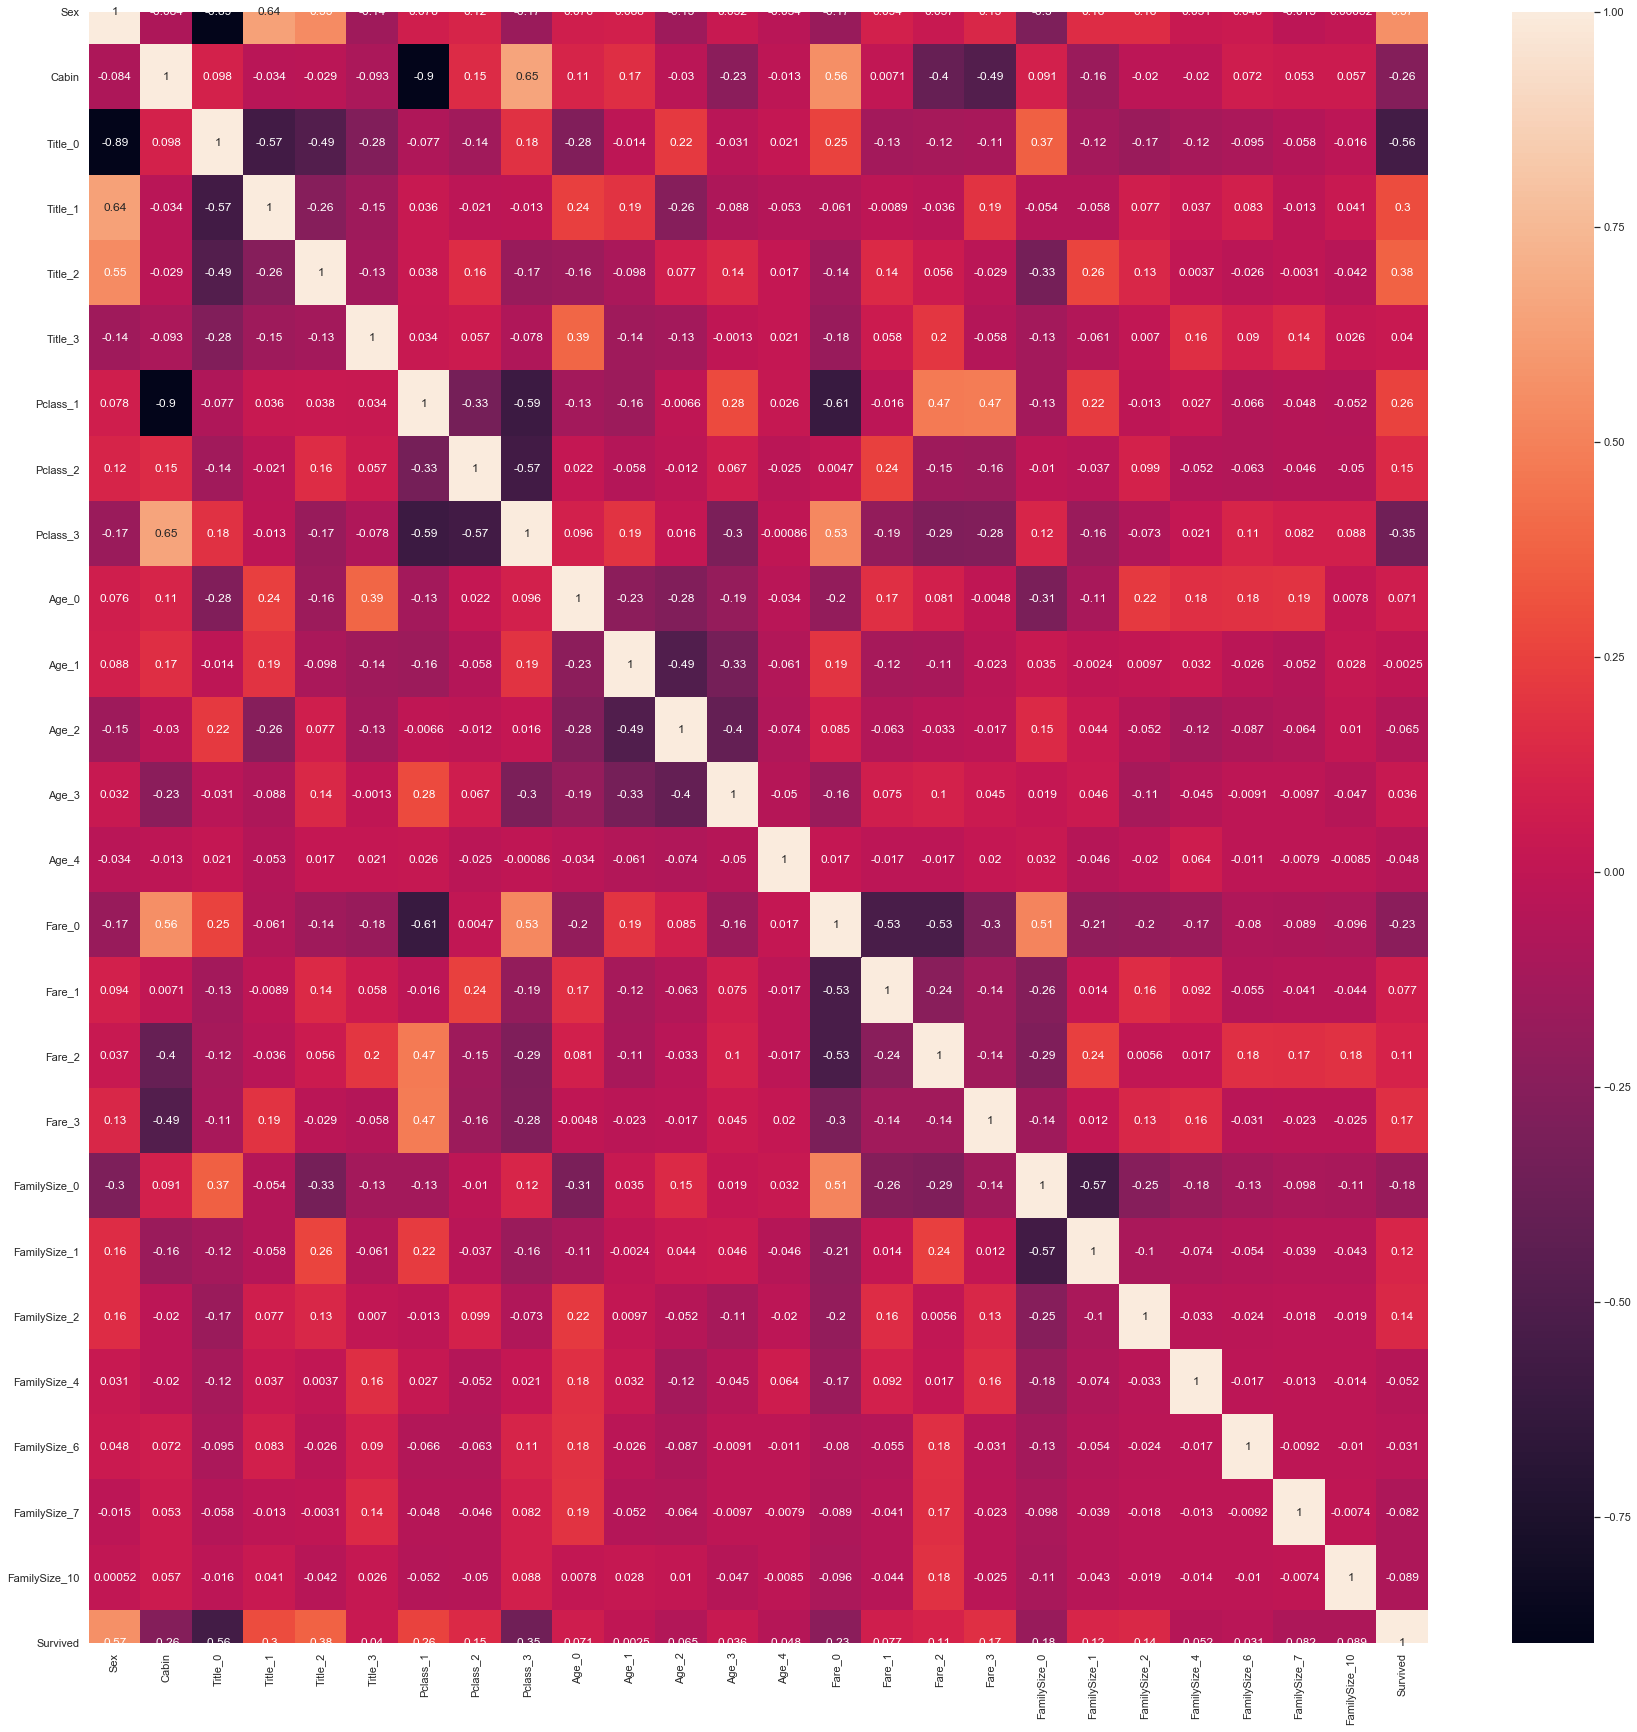

In [268]:
d_co = pd.concat([dummy_b_x,dummy_b_y],axis=1)
d_co = d_co.corr()
ax = sns.heatmap(d_co, annot=True, fmt='.2g')

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


[0.23210807 0.0878157  0.21931037 0.00809419 0.0386462  0.01439718
 0.04721535 0.02864583 0.05448548 0.01525494 0.01770709 0.02083496
 0.02475267 0.00410233 0.04200162 0.01431303 0.02924571 0.00455553
 0.02911534 0.01977907 0.01888897 0.01889618 0.00322626 0.00357802
 0.00302994]


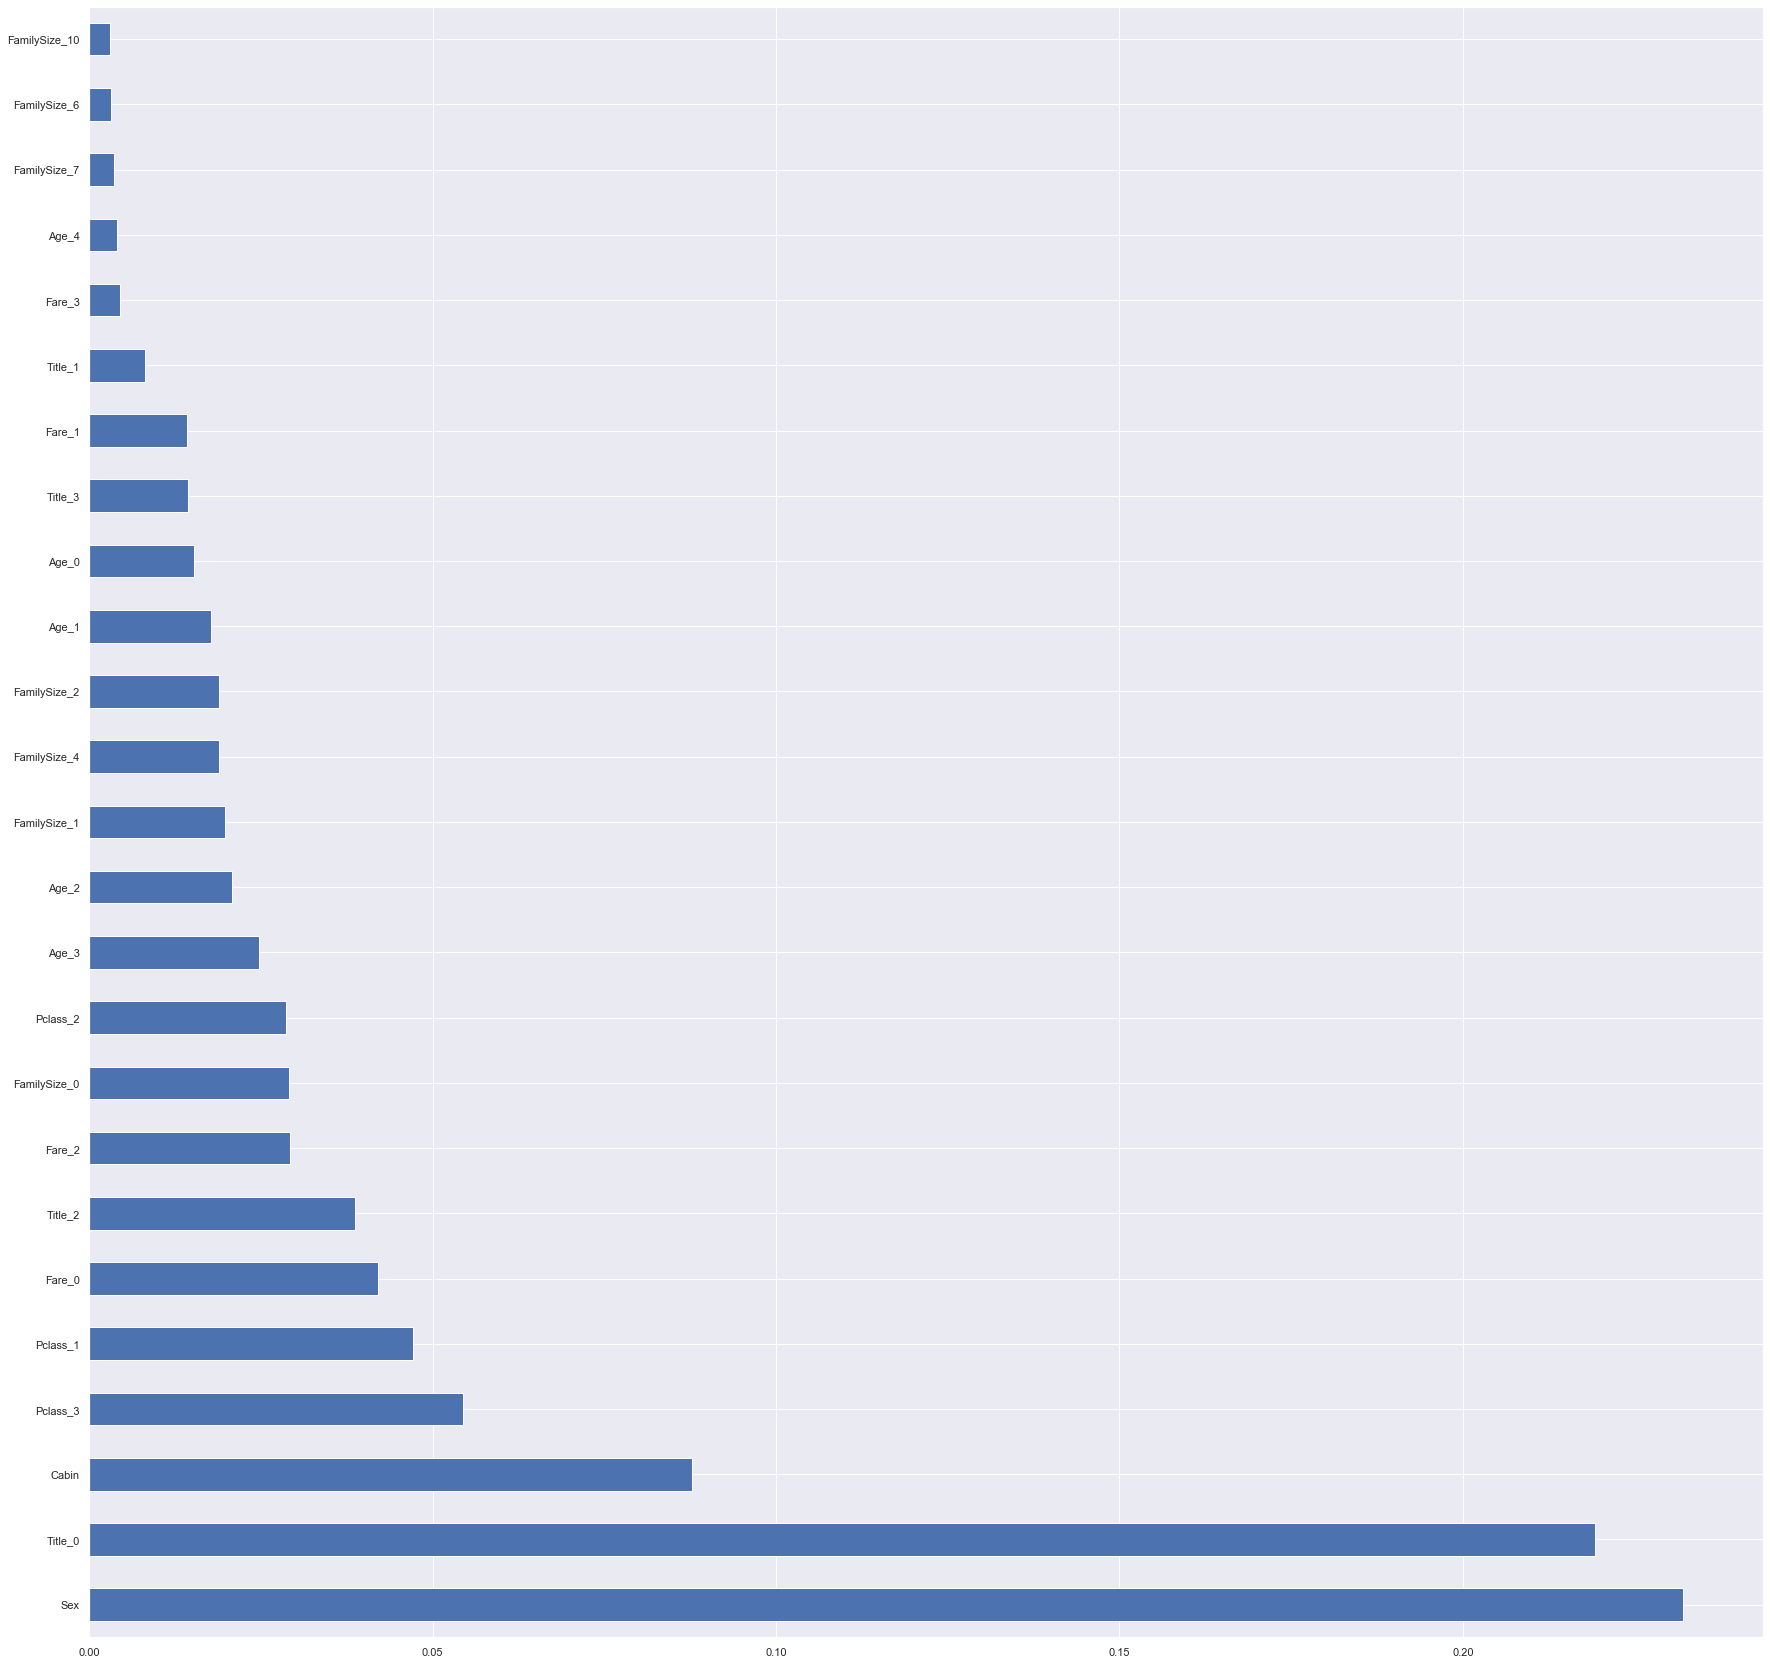

In [269]:
# Feature importance

from sklearn.ensemble import ExtraTreesClassifier
d_model = ExtraTreesClassifier()
d_model.fit(dummy_b_x,dummy_b_y)
print(d_model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
d_feat_importances = pd.Series(d_model.feature_importances_, index=dummy_b_x.columns)
d_feat_importances.nlargest(30).plot(kind='barh')
plt.show()


In [293]:
lg_clf = LogisticRegression()
d_selector = RFE(lg_clf,25,step=1)
d_selector.fit(dummy_b_x,dummy_b_y)

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='warn', n_jobs=None, penalty='l2',
                                 random_state=None, solver='warn', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=25, step=1, verbose=0)

In [294]:
d_ranking= d_selector.ranking_
pd.DataFrame({'feature':list(dummy_b_x.columns),'ranking':d_ranking})

,feature,ranking
0,Sex,1
1,Cabin,1
2,Title_0,1
3,Title_1,1
4,Title_2,1
5,Title_3,1
6,Pclass_1,1
7,Pclass_2,1
8,Pclass_3,1
9,Age_0,1


In [295]:
sel_dummy = dummy_b_x.iloc[:,[0,]]

In [286]:
vt_clf.fit(dummy_b_x,dummy_b_y)

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingClassifier(estimators=[('xgboost',
                              GradientBoostingClassifier(criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                          

In [287]:
vt_clf.score(dummy_b_x,dummy_b_y)

0.8490990990990991

In [288]:
d_pred = vt_clf.predict(d_x_test)

In [289]:
d_ac = accuracy_score(d_y_test,d_pred)
d_ac

0.8491620111731844

In [290]:
d_f1 = f1_score(d_y_test,d_pred)
d_f1

0.8057553956834532

In [277]:
d_cm = confusion_matrix(d_y_test,d_pred)
d_cm

array([[94, 11],
       [16, 58]], dtype=int64)

# dummy varaible for y test

In [192]:
test_first['Title'].value_counts()

0.0    241
1.0     78
2.0     72
3.0     27
Name: Title, dtype: int64

In [197]:
t_t0 = []
for j in test_first['Title']:
    if j == 0:
        t_t0.append(1)
    else: 
        t_t0.append(0)
test_first['Title_0']= t_t0        

In [198]:
t_t1 = []
for j in test_first['Title']:
    if j == 1:
        t_t1.append(1)
    else: 
        t_t1.append(0)
test_first['Title_1']= t_t1        

In [199]:
t_t2 = []
for j in test_first['Title']:
    if j == 2:
        t_t2.append(1)
    else: 
        t_t2.append(0)
test_first['Title_2']= t_t2        

In [200]:
t_t3 = []
for j in test_first['Title']:
    if j == 3:
        t_t3.append(1)
    else: 
        t_t3.append(0)
test_first['Title_3']= t_t3     

In [201]:
test_first['Pclass'].value_counts()

3    218
1    107
2     93
Name: Pclass, dtype: int64

In [202]:
p_p1 = []
for j in test_first['Pclass']:
    if j == 1:
        p_p1.append(1)
    else: 
        p_p1.append(0)
test_first['Pclass_1']= p_p1     

In [203]:
p_p2 = []
for j in test_first['Pclass']:
    if j == 2:
        p_p2.append(1)
    else: 
        p_p2.append(0)
test_first['Pclass_2']= p_p2     

In [204]:
p_p3 = []
for j in test_first['Pclass']:
    if j == 3:
        p_p3.append(1)
    else: 
        p_p3.append(0)
test_first['Pclass_3']= p_p3     

In [205]:
test_first.Age.value_counts()

2.0    139
1.0    134
3.0     99
0.0     39
4.0      7
Name: Age, dtype: int64

In [206]:
a_a0 = []
for j in test_first['Age']:
    if j == 0:
        a_a0.append(1)
    else: 
        a_a0.append(0)
test_first['Age_0']= a_a0 

In [207]:
a_a1 = []
for j in test_first['Age']:
    if j == 1:
        a_a1.append(1)
    else: 
        a_a1.append(0)
test_first['Age_1']= a_a1 

In [208]:
a_a2 = []
for j in test_first['Age']:
    if j == 2:
        a_a2.append(1)
    else: 
        a_a2.append(0)
test_first['Age_2']= a_a2 

In [209]:
a_a3 = []
for j in test_first['Age']:
    if j == 3:
        a_a3.append(1)
    else: 
        a_a3.append(0)
test_first['Age_3']= a_a3 

In [210]:
a_a4 = []
for j in test_first['Age']:
    if j == 4:
        a_a4.append(1)
    else: 
        a_a4.append(0)
test_first['Age_4']= a_a4 

In [211]:
test_first.Fare.value_counts()

0.0    236
2.0     78
1.0     73
3.0     31
Name: Fare, dtype: int64

In [212]:
f_f0 = []
for j in test_first['Fare']:
    if j == 0:
        f_f0.append(1)
    else: 
        f_f0.append(0)
test_first['Fare_0']= f_f0 

In [214]:
f_f1 = []
for j in test_first['Fare']:
    if j == 1:
        f_f1.append(1)
    else: 
        f_f1.append(0)
test_first['Fare_1']= f_f1 

In [215]:
f_f2 = []
for j in test_first['Fare']:
    if j == 2:
        f_f2.append(1)
    else: 
        f_f2.append(0)
test_first['Fare_2']= f_f2 

In [216]:
f_f3 = []
for j in test_first['Fare']:
    if j == 3:
        f_f3.append(1)
    else: 
        f_f3.append(0)
test_first['Fare_3']= f_f3 

In [217]:
test_first.FamilySize.value_counts()

0     253
1      74
2      57
3      14
4       7
10      4
6       4
5       3
7       2
Name: FamilySize, dtype: int64

In [220]:
Fs_s0 = []
for j in test_first['FamilySize']:
    if j == 0:
        Fs_s0.append(1)
    else: 
        Fs_s0.append(0)
test_first['FamilySize_0']= Fs_s0 

In [221]:
Fs_s1 = []
for j in test_first['FamilySize']:
    if j == 1:
        Fs_s1.append(1)
    else: 
        Fs_s1.append(0)
test_first['FamilySize_1']= Fs_s1 

In [222]:
Fs_s2 = []
for j in test_first['FamilySize']:
    if j == 2:
        Fs_s2.append(1)
    else: 
        Fs_s2.append(0)
test_first['FamilySize_2']= Fs_s2 

In [223]:
Fs_s3 = []
for j in test_first['FamilySize']:
    if j == 3:
        Fs_s3.append(1)
    else: 
        Fs_s3.append(0)
test_first['FamilySize_2']= Fs_s3 

In [224]:
Fs_s4 = []
for j in test_first['FamilySize']:
    if j == 4:
        Fs_s4.append(1)
    else: 
        Fs_s4.append(0)
test_first['FamilySize_4']= Fs_s4 

In [225]:
Fs_s5 = []
for j in test_first['FamilySize']:
    if j == 5:
        Fs_s5.append(1)
    else: 
        Fs_s5.append(0)
test_first['FamilySize_4']= Fs_s5 

In [226]:
Fs_s6 = []
for j in test_first['FamilySize']:
    if j == 6:
        Fs_s6.append(1)
    else: 
        Fs_s6.append(0)
test_first['FamilySize_6']= Fs_s6 

In [227]:
Fs_s7 = []
for j in test_first['FamilySize']:
    if j == 7:
        Fs_s7.append(1)
    else: 
        Fs_s7.append(0)
test_first['FamilySize_7']= Fs_s7 

In [228]:
Fs_s10 = []
for j in test_first['FamilySize']:
    if j == 10:
        Fs_s10.append(1)
    else: 
        Fs_s10.append(0)
test_first['FamilySize_10']= Fs_s10 

In [229]:
test_first

,Sex,Title,Pclass,Age,Fare,FamilySize,Cabin,Title_0,Title_1,Title_2,...,Fare_1,Fare_2,Fare_3,FamilySize_1,FamilySize_0,FamilySize_2,FamilySize_4,FamilySize_6,FamilySize_7,FamilySize_10
0,0,0.0,3,2.0,0.0,0,5.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,2.0,3,3.0,0.0,1,5.0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0,0.0,2,3.0,0.0,0,5.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0.0,3,2.0,0.0,0,5.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,2.0,3,1.0,0.0,2,5.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,0.0,3,2.0,0.0,0,5.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
414,1,0.0,1,3.0,3.0,0,2.0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
415,0,0.0,3,3.0,0.0,0,5.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
416,0,0.0,3,2.0,0.0,0,5.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [230]:
test_dummy_x = test_first.iloc[:,[0,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]]

In [231]:
test_dummy_x

,Sex,Cabin,Title_0,Title_1,Title_2,Title_3,Pclass_1,Pclass_2,Pclass_3,Age_0,...,Fare_1,Fare_2,Fare_3,FamilySize_1,FamilySize_0,FamilySize_2,FamilySize_4,FamilySize_6,FamilySize_7,FamilySize_10
0,0,5.0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,5.0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0,5.0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,5.0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,1,5.0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,5.0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
414,1,2.0,1,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
415,0,5.0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
416,0,5.0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


# prediction

In [233]:
dummy_prediction = vt_clf.predict(test_dummy_x)

In [234]:
dummy_prediction

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

# save the file

In [235]:
submission = pd.DataFrame(test_sample.iloc[:,0])
submission['survived'] = dummy_prediction

In [236]:
submission

,PassengerId,survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [237]:
submission.to_csv('submission.csv',index = False)

In [238]:
submission

,PassengerId,survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
